In [2]:
import nest
import numpy as np
import numpy.ma as ma

from lsm.nest import LSM
from lsm.utils import poisson_generator

import matplotlib.pyplot as plot

# convention: all times in [ms], except stated otherwise


def generate_stimulus_xor(stim_times, gen_burst, n_inputs=2):
    inp_states = np.random.randint(2, size=(n_inputs, np.size(stim_times)))
    inp_spikes = []

    for times in ma.masked_values(inp_states, 0) * stim_times:
        # for each input (neuron): generate spikes according to state (=1) and stimulus time-grid
        spikes = np.concatenate([t + gen_burst() for t in times.compressed()])

        # round to simulation precision
        spikes *= 10
        spikes = spikes.round() + 1.0
        spikes = spikes / 10.0

        inp_spikes.append(spikes)

    # astype(int) could be omitted, because False/True has the same semantics
    targets = np.logical_xor(*inp_states).astype(int)
    print(inp_states.shape)
    return inp_spikes, targets


def generate_stimulus_olf(stim_times, gen_burst, n_inputs=2):
    inp_states = np.random.randint(2, size=(n_inputs, np.size(stim_times)))
    inp_spikes = []

    for times in ma.masked_values(inp_states, 0) * stim_times:
        # for each input (neuron): generate spikes according to state (=1) and stimulus time-grid
        spikes = np.concatenate([t + gen_burst() for t in times.compressed()])

        # round to simulation precision
        spikes *= 10
        spikes = spikes.round() + 1.0
        spikes = spikes / 10.0

        inp_spikes.append(spikes)

    # astype(int) could be omitted, because False/True has the same semantics
#     targets = inp_states[0]
    targets = np.logical_and(*inp_states).astype(int)
    bound = 8
    for i in range(len(targets)):
        if np.random.randint(1,bound)%bound-1 == 0:
            targets[i] = np.random.randint(0,2)
            
    print(inp_states.shape)
    return inp_spikes, targets


def inject_spikes(inp_spikes, neuron_targets):
    spike_generators = nest.Create("spike_generator", len(inp_spikes))

    for sg, sp in zip(spike_generators, inp_spikes):
        nest.SetStatus([sg], {'spike_times': sp})

    delay = dict(distribution='normal_clipped', mu=10., sigma=20., low=3., high=200.)
    C_inp = 100  # int(N_E / 20)  # number of outgoing input synapses per input neuron

    nest.Connect(spike_generators, neuron_targets,
                 {'rule': 'fixed_outdegree',
                  'outdegree': C_inp},
                 {'model': 'static_synapse',
                  'delay': delay,
                  'weight': {'distribution': 'uniform',
                             'low': 2.5 * 10 * 5.0,
                             'high': 7.5 * 10 * 5.0}
                  })


# nest.SetKernelStatus({'print_time': True, 'local_num_threads': 11})

In [2]:
sim_time = 200000

# stimulus
stim_interval = 300
stim_length = 50
stim_rate = 200  # [1/s]

readout_delay = 10

stim_times = np.arange(stim_interval, sim_time - stim_length - readout_delay, stim_interval)
readout_times = stim_times + stim_length + readout_delay

def gen_stimulus_pattern(): return poisson_generator(stim_rate, t_stop=stim_length)

inp_spikes, targets = generate_stimulus_olf(stim_times, gen_burst=gen_stimulus_pattern)

lsm = LSM(n_exc=1000, n_inh=250, n_rec=500)

inject_spikes(inp_spikes, lsm.inp_nodes)

# nest.SetKernelStatus({'print_time': True, 'local_num_threads': 11})

(2, 666)
LSM constructed


In [3]:
nest.Simulate(sim_time)

In [4]:

readout_times = readout_times[5:]
targets = targets[5:]

states = lsm.get_states(readout_times, tau=20)

# add constant component to states for bias (TODO why?)
states = np.hstack([states, np.ones((np.size(states, 0), 1))])

n_examples = np.size(targets, 0)
n_examples_train = int(n_examples * 0.8)

train_states, test_states = states[:n_examples_train, :], states[n_examples_train:, :]
train_targets, test_targets = targets[:n_examples_train], targets[n_examples_train:]

readout_weights = lsm.compute_readout_weights(train_states, train_targets, reg_fact=5.0)

In [5]:
def classify(prediction):
    return (prediction >= 0.5).astype(int)

train_prediction = lsm.compute_prediction(train_states, readout_weights)
train_results = classify(train_prediction)

test_prediction = lsm.compute_prediction(test_states, readout_weights)
test_results = classify(test_prediction)

print("simulation time: {}ms".format(sim_time))
print("number of stimuli: {}".format(len(stim_times)))
print("size of each state: {}".format(np.size(states, 1)))

print("---------------------------------------")

def eval_prediction(prediction, targets, label):
    n_fails = sum(abs(prediction - targets))
    n_total = len(targets)
    print("mismatched {} examples: {:d}/{:d} [{:.1f}%]".format(label, n_fails, n_total, n_fails / n_total * 100))

eval_prediction(train_results, train_targets, "training")
eval_prediction(test_results, test_targets, "test")

simulation time: 200000ms
number of stimuli: 666
size of each state: 501
---------------------------------------
mismatched training examples: 5/528 [0.9%]
mismatched test examples: 20/133 [15.0%]


bound = 3


## w_scale = 1000.00
mismatched training examples: 0/528 [0.0%]
mismatched test examples: 64/133 [48.1%]


## w_scale = 100.00
mismatched training examples: 0/528 [0.0%]
mismatched test examples: 59/133 [44.4%]


## w_scale = 10.00
mismatched training examples: 204/528 [38.6%]
mismatched test examples: 59/133 [44.4%]

## w_scale = 5
mismatched training examples: 44/528 [8.3%]
mismatched test examples: 45/133 [33.8%]


## w_scale = 1.00
mismatched training examples: 95/528 [18.0%]
mismatched test examples: 41/133 [30.8%]

## w_scale = 0.10
mismatched training examples: 107/528 [20.3%]
mismatched test examples: 39/133 [29.3%]

##  w_scale = 0.010
mismatched training examples: 105/528 [19.9%]
mismatched test examples: 38/133 [28.6%]

##  w_scale = 0.00010
mismatched training examples: 106/528 [20.1%]
mismatched test examples: 45/133 [33.8%]



In [6]:
print("a")

a


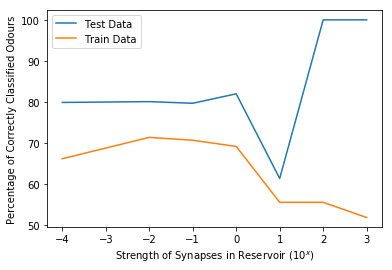

In [7]:
w = [1000,100,10,1,0.1,0.01,0.0001]
test = [0,0,38.6,18,20.3,19.9,20.1]
train = [48.1,44.4,44.4,30.8,29.3,28.6,33.8]

w = np.log10(w)
test = [100 - i for i in test]
train = [100 - i for i in train]

plot.plot(w,test)
plot.plot(w,train)
plot.legend(["Test Data","Train Data"])
plot.xlabel("Strength of Synapses in Reservoir ($10^x$)")
plot.ylabel("Percentage of Correctly Classified Odours")
plot.show()



In [8]:
np.log10([10,100,10])

array([1., 2., 1.])

next investigated modifying the sigma argument in the distribution of weights

### 0.0
mismatched training examples: 1/528 [0.2%]

mismatched test examples: 15/133 [11.3%]

### 0.125
mismatched training examples: 2/528 [0.4%]

mismatched test examples: 13/133 [9.8%]


### 0.25
mismatched training examples: 4/528 [0.8%]

mismatched test examples: 20/133 [15.0%]


### 0.375
mismatched training examples: 2/528 [0.4%]

mismatched test examples: 15/133 [11.3%]



### 0.5
mismatched training examples: 4/528 [0.8%]

mismatched test examples: 17/133 [12.8%]

### 0.75
mismatched training examples: 5/528 [0.9%]
mismatched test examples: 20/133 [15.0%]



### 1.0
mismatched training examples: 6/528 [1.1%]

mismatched test examples: 15/133 [11.3%]

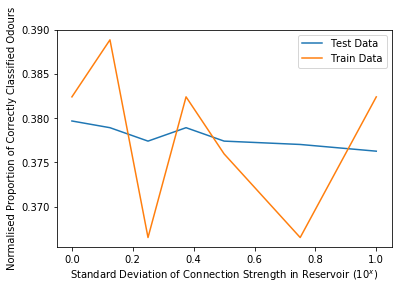

In [3]:
w = [0,0.125,0.25,0.375,0.5,0.75,1]
test = [11.3,9.8,15,11.3,12.8,15.0,11.3]
train = [0.2,0.4,0.8,0.4,0.8,0.9,1.1]

# w = np.log10(w)
test = [(100 - i) for i in test]
train = [(100 - i)for i in train]

trainNorm = train/np.linalg.norm(train)
testNorm = test/np.linalg.norm(test)

plot.plot(w,trainNorm)
plot.plot(w,testNorm)
plot.legend(["Test Data","Train Data"])
plot.xlabel("Standard Deviation of Connection Strength in Reservoir ($10^x$)")
plot.ylabel("Normalised Proportion of Correctly Classified Odours")
plot.show()

In [11]:
test

[7.178034682080924,
 7.299421965317919,
 6.878612716763006,
 7.178034682080924,
 7.05664739884393,
 6.878612716763006,
 7.178034682080924]

In [19]:
trainNorm = np.linalg.norm(train)
testNorm = np.linalg.norm(test)

In [22]:
train/trainNorm


array([0.37970199, 0.37894106, 0.37741921, 0.37894106, 0.37741921,
       0.37703875, 0.37627782])

In [27]:
list(test/testNorm)

[0.382437912550612,
 0.3889052955137001,
 0.3664850345749946,
 0.382437912550612,
 0.37597052958752386,
 0.3664850345749946,
 0.382437912550612]

In [24]:
w

[0, 0.125, 0.25, 0.375, 0.5, 0.75, 1]

In [30]:
trainNorm

262.83770657955455